In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

2023-12-23 22:42:52.969469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 22:42:53.137996: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2023-12-23 22:42:54.145487: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-23 22:42:54.145590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-23 22:42:54.145597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
with tf.compat.v1.Session(config=config) as sess:

    # 메모리 40% 할당
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.9
    sess = tf.compat.v1.Session(config=config)

2023-12-23 22:42:55.058600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-12-23 22:42:55.999548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
2023-12-23 22:42:56.020594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [3]:
import pickle

with open('./Pretraning_data/ZINC_10M_data','rb') as file:
    train = pickle.load(file)

In [4]:
train[1]

'O=C(NC(=O)c1cccc(F)c1)O[C@H]1CCS(=O)(=O)C1'

In [5]:
from Module import RDK
RDK.smile_tokenize(train[1:5])

[['O=C(N', 'C(=O)', 'c1cccc(F)', 'c1)O', '[C@H]1CC', 'S(=O)(=O)C1'],
 ['C',
  'n1ccnc1C',
  '[N@@H+]1C',
  '[C@@H](O)',
  '[C@H](O',
  'c2cccc(',
  'C(=O)[O-])',
  'c2)C1'],
 ['C',
  'n1ccnc1C',
  '[N@H+]1C',
  '[C@@H](O)',
  '[C@H](O',
  'c2cccc(',
  'C(=O)[O-])',
  'c2)C1'],
 ['CS(=O)(=O)', 'c1cn[nH]c1', '[C@H]1CC', 'N(C(=O)', 'c2cnccn2)', 'C1']]

In [6]:
from Module import RDK
RDK.smile_tokenize(train[1:5])


[['O=C(', 'NC(=O)', 'c1cccc(F)c1)', 'O[C@H]1', 'CCS(=O)(=O)', 'C1'],
 ['Cn1cc',
  'nc1C',
  '[N@@H+]',
  '1',
  'C[C@@H](O)',
  '[C@H](O',
  'c2cccc(',
  'C(=O)',
  '[O-])',
  'c2)C1'],
 ['Cn1cc',
  'nc1C',
  '[N@H+]',
  '1',
  'C[C@@H](O)',
  '[C@H](O',
  'c2cccc(',
  'C(=O)',
  '[O-])',
  'c2)C1'],
 ['CS(=O)(=O)',
  'c1cn',
  '[nH]c1',
  '[C@H]1',
  'CCN(C(=O)',
  'c2cn',
  'cc',
  'n2)C1']]

In [4]:
from rdkit import Chem
from tqdm import tqdm
def Chem_generator(smiles):
    res_list = []
    for i in tqdm(smiles):
        mol = Chem.MolFromSmiles(i)
        temp = []
        index = 0
        while(len(set(temp))!=4 and index != 100):
            index+=1
            temp.append(Chem.MolToSmiles(mol,doRandom=True))
        res_list+=list(set(temp))
    return res_list

In [7]:
train_1 = Chem_generator(train)

  0%|          | 1849/12525050 [00:01<1:56:13, 1795.88it/s]

100%|██████████| 12525050/12525050 [1:25:08<00:00, 2451.74it/s]


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
def scaled_dot_product(Q,K,V):
        mat_QK = tf.matmul(Q,K,transpose_b=True)
        depth = tf.cast(tf.shape(K)[-1], tf.float32)
        logits = mat_QK / tf.math.sqrt(depth)
    

        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, V)

        return output, attention_weights

class self_multihead(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,name='multiheadatten'):
        super(self_multihead,self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model%num_heads == 0

        self.depth = d_model//self.num_heads
        self.Q = Dense(units=d_model)
        self.K = Dense(units=d_model)
        self.V = Dense(units=d_model)

        self.linear = Dense(units = d_model)

    def split(self,inputs,batch_size):
        inputs = tf.reshape(inputs, [batch_size,-1,self.num_heads,self.depth])
        return tf.transpose(inputs,perm=[0,2,1,3])

    def call(self,inputs):
        Q,K,V = inputs,inputs,inputs
        batch_size = tf.shape(Q)[0]
        
        # Denselayer
        Q = self.Q(Q)
        K = self.K(K)
        V = self.V(V)
        #Splithead 

        Q = self.split(Q,batch_size)
        K = self.split(K,batch_size)
        V = self.split(V,batch_size)
        #Scaled dot product
        scaled_att,_ = scaled_dot_product(Q,K,V)
        #(batchsize,sentence_size,num_heads,word_size/num_heads)
        scaled_attention = tf.transpose(scaled_att, perm=[0,2,1,3])
        #Concate
        concat_attention = tf.reshape(scaled_attention, [batch_size, -1, self.d_model])
        #Linear Dense
        outputs = self.linear(concat_attention)

        return outputs



def scheduler(epochs,lr):
    lr = 0.5*(1+np.cos(np.pi * epochs / 100))
    if epochs <= 5:
        lr *= epochs * 1.0 / 30
    return lr

class transformer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,ff_dim,name):
        super(transformer,self).__init__(name=name)
        self.attn = self_multihead(d_model,num_heads)
        self.ff = Sequential([Dense(ff_dim,activation='relu'),Dense(d_model)])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
    
    def call(self, inputs):
        attn_out = self.attn(inputs)
        out1 = self.norm1(inputs + attn_out)
        ffn_output = self.ff(out1)
        return self.norm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        mask = self.token_emb.compute_mask(x)
        return x + positions
    

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,kernel_regularizer=l2_reg,dropout=0.1)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [6]:
def replace_zeros_with_ones(input_tensor):
    # input_tensor에서 0인 값을 1로 바꾸는 연산
    modified_tensor = tf.where(tf.equal(input_tensor, 0), 1, input_tensor)
    return modified_tensor


def calculate_means(input_list, index_ranges):
    # TensorFlow 상수로 입력 리스트를 변환
    input_tensor = tf.constant(input_list)
    
    # 각각의 인덱스 범위를 나누어 평균 계산
    averages = [tf.reduce_mean(input_tensor[start:end]) for start, end in index_ranges]
    
    return averages


class Mask(tf.keras.layers.Layer):
    def __init__(self):
        super(Mask, self).__init__()
    def call(self, inputs,mask):
        prob = np.random.rand(1)[0]
        if prob<0.8:
            return tf.multiply(inputs,((mask-1)*(-1)))
        elif prob>=0.8:
            random_value = tf.random.uniform(shape=[inputs.shape[0]], minval=0, maxval=inputs.shape[1], dtype=tf.int32)
            random_value = mask*random_value[:,tf.newaxis]
            random_value = replace_zeros_with_ones(random_value)
            return tf.multiply(inputs,(random_value))
        else:
            return inputs




class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        #self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        self.encoder = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,15000,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        
        for i in range(8):
            hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [7]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(1e-4) * tf.math.minimum(arg1, arg2)

temp_learning_rate_schedule = CustomSchedule(256,10000)
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

2023-12-19 09:54:33.895310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [8]:
from tdc.single_pred import Tox
from Module import RDK as rk
import atomInSmiles
from Module import Fine_tune
from SmilesPE import tokenizer

In [12]:
from multiprocessing import Pool
from tqdm import tqdm
from multiprocessing import Process, Value, Array
from multiprocessing import Process,Manager,current_process
from Module import RDK as rk
import atomInSmiles 
from SmilesPE import tokenizer
train_set = RDK.smile_tokenize(train_1)


Text(0, 0.5, 'counts')

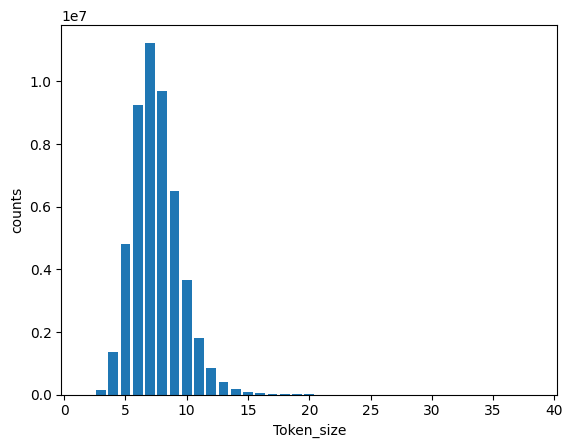

In [13]:
import matplotlib.pyplot as plt
length_list = {}


for index,i in enumerate(train_set):
    try:
        length_list[len(i)]=length_list[len(i)]+1
    except:
        length_list[len(i)] = 1
    
plt.bar(length_list.keys(),length_list.values())
plt.xlabel(xlabel='Token_size')
plt.ylabel('counts')    

In [14]:
temp_dict = {}
for i in train_set:
    for j in i:
        try:
            temp_dict[j] = temp_dict[j] + 1
        except:
            temp_dict[j] = 1
remove_dict = {}
for i in temp_dict.keys():
    if temp_dict[i]<50:
        print(i,temp_dict[i])
        remove_dict[i] = 1

remove_list = []
for index,i in enumerate(train_set):
    for j in i:
        try:
            remove_dict[j]
            remove_list.append(index)
            break
        except:
            continue

remove_list.sort(reverse=True)

[P@H+] 48
[P@@H+] 48
9 12
%10 4
[CH] 16
p 16
[CH2] 24
[Si-] 4
[P@+] 33
[P@@+] 31
[NH] 8
[17O] 12
[p+] 4


In [15]:
for i in remove_list:
    train_set.pop(i)
print(len(train_set))

50099943


In [9]:
import pickle
with open('./Pretraning_data/Random_ZINC_50M_SmilesPE_tokken.pkl','rb') as file:
    train_set = pickle.load(file)

In [10]:
import pickle
molecule_dictionary = {'<start>':1,'<end>':2,'<unknown1>':3,'<unknown2>':4,'<unknown3>':5,'<unknow4>':6,'<unknown5>':7}

for molecule in train_set:
    for atom in molecule:
        try:
            molecule_dictionary[atom]
        except:
            molecule_dictionary[atom] = len(molecule_dictionary)+1
with open('./BERT/SmiletoPE/1M_random_ZINC_word2index.pkl','wb') as file:
    pickle.dump(molecule_dictionary,file)
len(molecule_dictionary)

10576

In [6]:
import pickle
with open('./BERT/SmiletoPE/1M_random_ZINC_word2index.pkl','rb') as file:
    molecule_dictionary = pickle.load(file)

In [11]:
from tqdm import tqdm
import numpy as np 

def word_to_index(train_set,dict):
    result = []
    for molecule in tqdm(train_set):
        temp_list = []
        temp_list.append(1)
        for atom in molecule:
            temp_list.append(dict[atom])
        while len(temp_list)!=200:
            temp_list.append(0)
        result.append(temp_list)
    return result
embedding_word = word_to_index(train_set,molecule_dictionary)   
embedding_word = np.array(embedding_word)

100%|██████████| 50099943/50099943 [15:08<00:00, 55172.75it/s] 


In [7]:
from tdc.single_pred import Tox
from Module import RDK
import atomInSmiles

def word_to_index(train_set,dict):
    result = []
    for molecule in tqdm(train_set):
        temp_list = []
        temp_list.append(1)
        for atom in molecule:
            temp_list.append(dict[atom])
        while len(temp_list)!=200:
            temp_list.append(0)
        result.append(temp_list)
    return result
train_val,tox_info = Tox(name = 'AMES').get_data(format = 'DeepPurpose')
train_set_val = []

train_val = Chem_generator(train_val[:5000])

train_set_val = RDK.smile_tokenize(train_val)
val_remove_list = []
for index,i in enumerate(train_set_val):
    if len(i) < 3:
        val_remove_list.append(index)
        continue
    for j in i:
        try:
            molecule_dictionary[j]
        except:
            val_remove_list.append(index)
            break
val_remove_list.sort(reverse=True)

for i in val_remove_list:
    train_set_val.pop(i)

embedding_word_val = word_to_index(train_set_val,molecule_dictionary)   
embedding_word_val = np.array(embedding_word_val)

Found local copy...
Loading...
Done!
100%|██████████| 18760/18760 [00:00<00:00, 69083.69it/s]


In [8]:
embedding_word_val

array([[   1, 1903,  228, ...,    0,    0,    0],
       [   1, 1204, 1100, ...,    0,    0,    0],
       [   1,  777,  487, ...,    0,    0,    0],
       ...,
       [   1, 1366, 7797, ...,    0,    0,    0],
       [   1, 1983,  829, ...,    0,    0,    0],
       [   1, 5052,  147, ...,    0,    0,    0]])

In [9]:
import random
max = 16
mask_input_val = []
for j in tqdm(train_set_val):
        value = []
        number = int(len(j)*0.15)
        if number>max:
                max = number
        if number == 0:
                number = 1
        value += random.sample(range(1,len(j)),number)
        mask_input_val.append(value)
        
        
for j in mask_input_val:
        while(len(j)<max):
                j.append(-1)


random_value_val = embedding_word_val.copy()        
for _,index in enumerate(mask_input_val):
        for j in index:
                if j != -1:
                        prob = np.random.rand(1)[0]
                        if prob < 0.8:
                                random_value_val[_][j] = 0
                        elif prob > 0.9:
                                temp1 = random.sample(range(0,301),1)[0]
                                random_value_val[_][j] = temp1
                                
output_val = tf.multiply(tf.reduce_sum(tf.one_hot(mask_input_val,200),axis=1),embedding_word_val)

  0%|          | 0/18760 [00:00<?, ?it/s]

100%|██████████| 18760/18760 [00:00<00:00, 271375.80it/s]
2023-12-23 22:43:47.962150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import *
early_stopping_cb = EarlyStopping(patience=6, monitor='loss',restore_best_weights=True)

In [15]:
def custom_loss(y_true, y_pred):
    output = tf.one_hot(tf.cast(tf.boolean_mask(y_true,tf.cast(y_true,bool)),tf.int32),len(molecule_dictionary))
    loss = tf.keras.losses.CategoricalCrossentropy()(output,y_pred)
    return loss

In [16]:
def Custom_metric(y_true,y_pred):
    predictions = tf.argmax(y_pred,axis=1)
    true = tf.boolean_mask(y_true,tf.cast(y_true,bool))
    return  tf.metrics.Accuracy()(predictions,true)
def Mask_acc(y_true, y_pred):
    score = tf.py_function(func=Custom_metric, inp=[y_true, y_pred], Tout=tf.float32,  name='Custom_acc') 
    return score

In [17]:
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.transformer = TransformerBlock(emb_dim,num_heads,ff_dim)
        
        self.embedding = TokenAndPositionEmbedding(200,15000,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        
        hidden = self.embedding(inputs)
        for i in range(8):
            hidden = self.transformer(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = tf.boolean_mask(output,boolean_mask)
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            return output
        else:
            return hidden

In [29]:
import tensorflow as tf

def positional_encoding(max_position, d_model):
    """
    Positional encoding을 생성하는 함수
    Args:
    - max_position: 시퀀스의 최대 길이
    - d_model: 모델의 임베딩 차원 크기

    Returns:
    - positional_encoding: max_position x d_model 크기의 위치 인코딩 매트릭스
    """
    # 각 위치에 대한 1부터 d_model까지의 순차적인 정수를 생성합니다.
    position = tf.range(max_position, dtype=tf.float32)[:, tf.newaxis]

    # 2 * (임베딩 차원의 절반) 만큼의 값을 갖는 1/x 파형을 계산합니다.
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * (-tf.math.log(10000.0) / d_model))

    # 위치 인코딩 매트릭스를 계산합니다.
    positional_encoding = position * div_term
    positional_encoding = tf.stack([tf.math.sin(positional_encoding), tf.math.cos(positional_encoding)], axis=-1)
    positional_encoding = tf.reshape(positional_encoding, shape=(max_position, -1))

    return positional_encoding

# 테스트
max_position = 200  # 시퀀스의 최대 길이
d_model = 256  # 모델의 임베딩 차원 크기

pos_encoding = positional_encoding(max_position, d_model)
print("Positional Encoding shape:", pos_encoding.shape)

Positional Encoding shape: (200, 256)


In [34]:
def positional_encoding(max_position, d_model):
    """
    Positional encoding을 생성하는 함수
    Args:
    - max_position: 시퀀스의 최대 길이
    - d_model: 모델의 임베딩 차원 크기

    Returns:
    - positional_encoding: max_position x d_model 크기의 위치 인코딩 매트릭스
    """
    # 각 위치에 대한 1부터 d_model까지의 순차적인 정수를 생성합니다.
    position = tf.range(max_position, dtype=tf.float32)[:, tf.newaxis]

    # 2 * (임베딩 차원의 절반) 만큼의 값을 갖는 1/x 파형을 계산합니다.
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * (-tf.math.log(10000.0) / d_model))

    # 위치 인코딩 매트릭스를 계산합니다.
    positional_encoding = position * div_term
    positional_encoding = tf.stack([tf.math.sin(positional_encoding), tf.math.cos(positional_encoding)], axis=-1)
    positional_encoding = tf.reshape(positional_encoding, shape=(max_position, -1))

    return positional_encoding

# 테스트
max_position = 200  # 시퀀스의 최대 길이
d_model = 256  # 모델의 임베딩 차원 크기




class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = positional_encoding(maxlen,embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.token_emb(x)
        return x + self.pos_emb

In [35]:
pos_encoding

<tf.Tensor: shape=(200, 256), dtype=float32, numpy=
array([[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 8.4147102e-01,  5.4030228e-01,  8.0196184e-01, ...,
         1.0000000e+00,  1.0746076e-04,  1.0000000e+00],
       [ 9.0929747e-01, -4.1614681e-01,  9.5814437e-01, ...,
         1.0000000e+00,  2.1492151e-04,  1.0000000e+00],
       ...,
       [ 7.9580587e-01, -6.0555190e-01,  8.9584047e-01, ...,
         9.9974126e-01,  2.1168187e-02,  9.9977595e-01],
       [-7.9578593e-02, -9.9682862e-01,  8.9152521e-01, ...,
         9.9973863e-01,  2.1275625e-02,  9.9977362e-01],
       [-8.8179886e-01, -4.7162572e-01,  1.6930917e-01, ...,
         9.9973595e-01,  2.1383060e-02,  9.9977136e-01]], dtype=float32)>

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Embedding
inputs = Input(shape = (200,),dtype=tf.int32)
mask = Input(shape = (16), dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,mask,pretrain=True)

model = Model(inputs = [inputs,mask], outputs = [outputs])
model.summary()
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 bert_3 (BERT)                  (None, 10576)        23393386    ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
Total params: 23,393,386
Trainable params: 23,393,386
Non-trainable params: 0
______________

In [37]:
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)

In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.batch_count
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    self.batch_count += 1
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(1000.) * tf.math.minimum(arg1, arg2)

In [39]:
class CustomLearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=4000):
        super(CustomLearningRateScheduler, self).__init__()
        self.warmup_steps = warmup_steps
        self.step = tf.Variable(0, trainable=False)

    def __call__(self, step):
        self.step.assign_add(1)  # 각 배치가 지나갈 때마다 step 증가
        lr = tf.cond(
            self.step <= self.warmup_steps,
            lambda: (1e-4 - 1e-9) / self.warmup_steps * tf.cast(self.step, tf.float32) + 1e-9,
            lambda: 0.5 * (1e-4 + 1e-9) * (self.warmup_steps ** 0.5) / (tf.cast(self.step, tf.float32) ** 0.5)
        )
        return lr

In [40]:
lr = CustomLearningRateScheduler()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)

In [33]:
model.load_weights('./BERT/SmiletoPE/Random_ZINC_L_model_weights.h5')

In [41]:

import random
size = 300000
for k in range(1):
        for i in range(0,int(len(embedding_word)/size)):
                if k == 0:
                        i = i
                if i == int(len(embedding_word)/size):
                        break
                if i <80:
                        lr = (1e-4-1e-6)*(i)/80 + 1e-6
                else:
                        lr = 1e-4*np.sqrt(80)/np.sqrt(i)
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)
                max = 16
                mask_input = []
                for j in tqdm(train_set[size*i:size*(i+1)]):
                        value = []
                        number = int(len(j)*0.15)
                        if number>max:
                                number = max
                        if number == 0:
                                number = 1
                        value += random.sample(range(1,len(j)),number)
                        mask_input.append(value)
                        
                        
                for j in mask_input:
                        while(len(j)<max):
                                j.append(-1)
                
                
                
                
                
                
                inputs1 = embedding_word[size*i:size*(i+1)]
                inputs2 = mask_input
                output = tf.multiply(tf.reduce_sum(tf.one_hot(inputs2,200),axis=1),inputs1)

                
                random_value = inputs1.copy()        
                for _,index in enumerate(inputs2):
                        for j in index:
                                if j != -1:
                                        prob = np.random.rand(1)[0]
                                        if prob < 0.8:
                                                random_value[_][j] = 0
                                        elif prob > 0.9:
                                                temp1 = random.sample(range(0,301),1)[0]
                                                random_value[_][j] = temp1
                                                
                
                
                print(f'This is {i} number step')
                with tf.device('/device:GPU:0'):
                        if i % 20 == 0:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb],validation_data=([np.array(random_value_val),np.array(mask_input_val)],np.array(output_val)))
                        else:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb])
                        print(model.optimizer.lr)
                        model.save_weights('./BERT/SmiletoPE/Random_ZINC_L_model_weights.h5')

100%|██████████| 300000/300000 [00:00<00:00, 341540.13it/s]


This is 0 number step
  32/1172 [..............................] - ETA: 7:25 - loss: 32.5608 - Mask_acc: 0.0000e+00

KeyboardInterrupt: 

In [35]:
temp_weights = model.get_weights()
all_weights = temp_weights[:16]*8 + temp_weights[16:]

In [42]:
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        #self.encoder = TransformerBlock(emb_dim,num_heads,ff_dim)
        #self.normalize = tf.keras.layers.LayerNormalization(epsilon=1e-8)
        
        self.embedding = TokenAndPositionEmbedding(200,15000,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [44]:
inputs = Input(shape = (200,),dtype=tf.int32)
mask = Input(shape = (16), dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,mask,pretrain=True)

model = Model(inputs = [inputs,mask], outputs = [outputs])
model.summary()
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 bert_5 (BERT)                  (None, 10576)        23393386    ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
Total params: 23,393,386
Trainable params: 23,393,386
Non-trainable params: 0
______________

In [45]:
random_value_val

array([[   1,  409, 2790, ...,    0,    0,    0],
       [   1, 1204, 1100, ...,    0,    0,    0],
       [   1, 1903,  228, ...,    0,    0,    0],
       ...,
       [   1, 1983,    0, ...,    0,    0,    0],
       [   1, 5052,    0, ...,    0,    0,    0],
       [   1,    0,  829, ...,    0,    0,    0]])

In [46]:
import random
size = 300000
for k in range(11):
        for i in range(0,int(len(embedding_word)/size)):
                if k == 1:
                        i = i
                if i == int(len(embedding_word)/size):
                        break
                if i <80:
                        lr = (1e-4-1e-6)*(i)/80 + 1e-6
                else:
                        lr = 1e-4*np.sqrt(80)/np.sqrt(i)
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)
                max = 16
                mask_input = []
                for j in tqdm(train_set[size*i:size*(i+1)]):
                        value = []
                        number = int(len(j)*0.15)
                        if number>max:
                                number = max
                        if number == 0:
                                number = 1
                        value += random.sample(range(1,len(j)),number)
                        mask_input.append(value)
                        
                        
                for j in mask_input:
                        while(len(j)<max):
                                j.append(-1)
                
                
                
                
                
                
                inputs1 = embedding_word[size*i:size*(i+1)]
                inputs2 = mask_input
                output = tf.multiply(tf.reduce_sum(tf.one_hot(inputs2,200),axis=1),inputs1)

                
                random_value = inputs1.copy()        
                for _,index in enumerate(inputs2):
                        for j in index:
                                if j != -1:
                                        prob = np.random.rand(1)[0]
                                        if prob < 0.8:
                                                random_value[_][j] = 0
                                        elif prob > 0.9:
                                                temp1 = random.sample(range(0,301),1)[0]
                                                random_value[_][j] = temp1
                                                
                
                
                print(f'This is {i} number step')
                with tf.device('/device:GPU:0'):
                        if i % 20 == 0:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb],validation_data=([np.array(random_value_val),np.array(mask_input_val)],np.array(output_val)))
                        else:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb])
                        print(model.optimizer.lr)
                        model.save_weights('./BERT/SMILE/Random_ZINC_L_model_weights.h5')

100%|██████████| 300000/300000 [00:00<00:00, 342400.55it/s]


This is 0 number step
1172/1172 [==============================] - 455s 374ms/step - loss: 31.3052 - Mask_acc: 5.0223e-04 - val_loss: 30.0894 - val_Mask_acc: 0.0010
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-06>


100%|██████████| 300000/300000 [00:00<00:00, 337906.24it/s]


This is 1 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 27.6620 - Mask_acc: 0.0029
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2.2375e-06>


100%|██████████| 300000/300000 [00:00<00:00, 346390.02it/s]


This is 2 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 22.6307 - Mask_acc: 0.0038
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3.475e-06>


100%|██████████| 300000/300000 [00:00<00:00, 345685.25it/s]


This is 3 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 17.5368 - Mask_acc: 0.0065
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4.7125e-06>


100%|██████████| 300000/300000 [00:41<00:00, 7157.86it/s]  


This is 4 number step
1172/1172 [==============================] - 444s 364ms/step - loss: 13.5789 - Mask_acc: 0.0066
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5.95e-06>


100%|██████████| 300000/300000 [00:00<00:00, 330519.37it/s]


This is 5 number step
1172/1172 [==============================] - 450s 369ms/step - loss: 10.3273 - Mask_acc: 0.0090
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.1875e-06>


100%|██████████| 300000/300000 [00:00<00:00, 342638.86it/s]


This is 6 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 8.5294 - Mask_acc: 0.0076
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=8.425e-06>


100%|██████████| 300000/300000 [00:00<00:00, 344299.44it/s]


This is 7 number step
1172/1172 [==============================] - 445s 365ms/step - loss: 7.8974 - Mask_acc: 0.0078
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.6625e-06>


100%|██████████| 300000/300000 [00:00<00:00, 347132.34it/s]


This is 8 number step
1172/1172 [==============================] - 445s 365ms/step - loss: 7.9008 - Mask_acc: 0.0075
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.09e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343926.21it/s]


This is 9 number step
1172/1172 [==============================] - 445s 365ms/step - loss: 7.8696 - Mask_acc: 0.0069
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.21375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343382.88it/s]


This is 10 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.8373 - Mask_acc: 0.0093
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.3375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343872.83it/s]


This is 11 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.8365 - Mask_acc: 0.0077
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.46125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342728.27it/s]


This is 12 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.8303 - Mask_acc: 0.0080
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.585e-05>


100%|██████████| 300000/300000 [00:00<00:00, 348738.06it/s]


This is 13 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.8585 - Mask_acc: 0.0077
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.70875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 348063.18it/s]


This is 14 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.8213 - Mask_acc: 0.0072
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.8325e-05>


100%|██████████| 300000/300000 [00:00<00:00, 348289.58it/s]


This is 15 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.7846 - Mask_acc: 0.0078
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.95625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 347374.99it/s]


This is 16 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.8081 - Mask_acc: 0.0085
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2.08e-05>


100%|██████████| 300000/300000 [00:00<00:00, 344718.90it/s]


This is 17 number step
1172/1172 [==============================] - 441s 362ms/step - loss: 7.8040 - Mask_acc: 0.0108
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2.20375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 334032.80it/s]


This is 18 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.7550 - Mask_acc: 0.0119
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2.3275e-05>


100%|██████████| 300000/300000 [00:00<00:00, 350724.32it/s]


This is 19 number step
1172/1172 [==============================] - 445s 366ms/step - loss: 7.6822 - Mask_acc: 0.0145
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2.45125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342689.44it/s]


This is 20 number step
1172/1172 [==============================] - 455s 375ms/step - loss: 7.7025 - Mask_acc: 0.0163 - val_loss: 7.5083 - val_Mask_acc: 0.0279
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2.575e-05>


100%|██████████| 300000/300000 [00:00<00:00, 340633.75it/s]


This is 21 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.6734 - Mask_acc: 0.0196
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2.69875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 340364.15it/s]


This is 22 number step
1172/1172 [==============================] - 441s 362ms/step - loss: 7.6111 - Mask_acc: 0.0244
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2.8225e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342598.00it/s]


This is 23 number step
1172/1172 [==============================] - 441s 362ms/step - loss: 7.6375 - Mask_acc: 0.0277
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2.94625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 339322.01it/s]


This is 24 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.6274 - Mask_acc: 0.0312
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3.07e-05>


100%|██████████| 300000/300000 [00:00<00:00, 345767.80it/s]


This is 25 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.6219 - Mask_acc: 0.0336
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3.19375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 327380.16it/s]


This is 26 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.5605 - Mask_acc: 0.0392
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3.3175e-05>


100%|██████████| 300000/300000 [00:00<00:00, 339467.48it/s]


This is 27 number step
1172/1172 [==============================] - 444s 364ms/step - loss: 7.5186 - Mask_acc: 0.0445
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3.44125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 346140.75it/s]


This is 28 number step
1172/1172 [==============================] - 444s 364ms/step - loss: 7.5143 - Mask_acc: 0.0477
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3.565e-05>


100%|██████████| 300000/300000 [00:00<00:00, 345311.29it/s]


This is 29 number step
1172/1172 [==============================] - 445s 366ms/step - loss: 7.4727 - Mask_acc: 0.0517
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3.68875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 345654.20it/s]


This is 30 number step
1172/1172 [==============================] - 444s 364ms/step - loss: 7.4003 - Mask_acc: 0.0565
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3.8125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 333245.19it/s]


This is 31 number step
1172/1172 [==============================] - 444s 364ms/step - loss: 7.4377 - Mask_acc: 0.0568
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3.93625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 344295.58it/s]


This is 32 number step
1172/1172 [==============================] - 468s 363ms/step - loss: 7.4623 - Mask_acc: 0.0585
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4.06e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343787.80it/s]


This is 33 number step
1172/1172 [==============================] - 443s 363ms/step - loss: 7.3656 - Mask_acc: 0.0609
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4.18375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343925.46it/s]


This is 34 number step
1172/1172 [==============================] - 445s 365ms/step - loss: 7.4551 - Mask_acc: 0.0611
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4.3075e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342910.77it/s]


This is 35 number step
1172/1172 [==============================] - 442s 363ms/step - loss: 7.3137 - Mask_acc: 0.0657
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4.43125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 345765.52it/s]


This is 36 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.4024 - Mask_acc: 0.0658
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4.555e-05>


100%|██████████| 300000/300000 [00:00<00:00, 344530.69it/s]


This is 37 number step
1172/1172 [==============================] - 442s 363ms/step - loss: 7.3698 - Mask_acc: 0.0662
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4.67875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 346380.20it/s]


This is 38 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.3667 - Mask_acc: 0.0681
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4.8025e-05>


100%|██████████| 300000/300000 [00:00<00:00, 336827.05it/s]


This is 39 number step
1172/1172 [==============================] - 443s 363ms/step - loss: 7.3354 - Mask_acc: 0.0710
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=4.92625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 344741.19it/s]


This is 40 number step
1172/1172 [==============================] - 454s 373ms/step - loss: 7.2661 - Mask_acc: 0.0719 - val_loss: 7.3621 - val_Mask_acc: 0.0779
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5.05e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343284.98it/s]


This is 41 number step
1172/1172 [==============================] - 440s 362ms/step - loss: 7.3097 - Mask_acc: 0.0723
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5.17375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343137.54it/s]


This is 42 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.3109 - Mask_acc: 0.0720
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5.2975e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342002.23it/s]


This is 43 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.3178 - Mask_acc: 0.0741
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5.42125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 347502.39it/s]


This is 44 number step
1172/1172 [==============================] - 445s 366ms/step - loss: 7.3181 - Mask_acc: 0.0746
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5.545e-05>


100%|██████████| 300000/300000 [00:00<00:00, 345151.69it/s]


This is 45 number step
1172/1172 [==============================] - 442s 363ms/step - loss: 7.2134 - Mask_acc: 0.0783
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5.66875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 349165.98it/s]


This is 46 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.2163 - Mask_acc: 0.0797
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5.7925e-05>


100%|██████████| 300000/300000 [00:00<00:00, 344064.36it/s]


This is 47 number step
1172/1172 [==============================] - 442s 364ms/step - loss: 7.2312 - Mask_acc: 0.0795
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5.91625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342615.82it/s]


This is 48 number step
1172/1172 [==============================] - 445s 365ms/step - loss: 7.1949 - Mask_acc: 0.0821
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.04e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343890.03it/s]


This is 49 number step
1172/1172 [==============================] - 445s 365ms/step - loss: 7.2077 - Mask_acc: 0.0816
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.16375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342991.63it/s]


This is 50 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.1581 - Mask_acc: 0.0837
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.2875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 344517.58it/s]


This is 51 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.2564 - Mask_acc: 0.0834
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.41125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 346964.73it/s]


This is 52 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.3055 - Mask_acc: 0.0807
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.535e-05>


100%|██████████| 300000/300000 [00:00<00:00, 341143.81it/s]


This is 53 number step
1172/1172 [==============================] - 442s 364ms/step - loss: 7.1272 - Mask_acc: 0.0857
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.65875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342276.12it/s]


This is 54 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.1600 - Mask_acc: 0.0845
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.7825e-05>


100%|██████████| 300000/300000 [00:00<00:00, 345982.00it/s]


This is 55 number step
1172/1172 [==============================] - 442s 364ms/step - loss: 7.2412 - Mask_acc: 0.0836
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.90625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 341960.60it/s]


This is 56 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.2704 - Mask_acc: 0.0827
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.03e-05>


100%|██████████| 300000/300000 [00:00<00:00, 344136.73it/s]


This is 57 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.2241 - Mask_acc: 0.0861
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.15375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 347429.94it/s]


This is 58 number step
1172/1172 [==============================] - 445s 365ms/step - loss: 7.1243 - Mask_acc: 0.0868
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.2775e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342303.30it/s]


This is 59 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.1511 - Mask_acc: 0.0880
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.40125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 344167.98it/s]


This is 60 number step
1172/1172 [==============================] - 459s 378ms/step - loss: 7.2295 - Mask_acc: 0.0860 - val_loss: 7.0310 - val_Mask_acc: 0.0957
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.525e-05>


100%|██████████| 300000/300000 [00:00<00:00, 354531.12it/s]


This is 61 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.2407 - Mask_acc: 0.0853
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.64875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 340480.93it/s]


This is 62 number step
1172/1172 [==============================] - 504s 365ms/step - loss: 7.1075 - Mask_acc: 0.0879
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.7725e-05>


100%|██████████| 300000/300000 [00:00<00:00, 332507.16it/s]


This is 63 number step
1172/1172 [==============================] - 441s 362ms/step - loss: 7.2358 - Mask_acc: 0.0863
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.89625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 341216.61it/s]


This is 64 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.2247 - Mask_acc: 0.0879
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=8.02e-05>


100%|██████████| 300000/300000 [00:00<00:00, 339458.96it/s]


This is 65 number step
1172/1172 [==============================] - 442s 364ms/step - loss: 7.2247 - Mask_acc: 0.0872
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=8.14375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 346920.16it/s]


This is 66 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.1578 - Mask_acc: 0.0888
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=8.2675e-05>


100%|██████████| 300000/300000 [00:00<00:00, 336921.20it/s]


This is 67 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.1642 - Mask_acc: 0.0890
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=8.39125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 344798.25it/s]


This is 68 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.1992 - Mask_acc: 0.0896
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=8.515e-05>


100%|██████████| 300000/300000 [00:00<00:00, 344906.84it/s]


This is 69 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.1826 - Mask_acc: 0.0914
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=8.63875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 345132.85it/s]


This is 70 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.2114 - Mask_acc: 0.0890
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=8.7625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 348976.95it/s]


This is 71 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.1271 - Mask_acc: 0.0921
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=8.88625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343081.87it/s]


This is 72 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.1587 - Mask_acc: 0.0916
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.01e-05>


100%|██████████| 300000/300000 [00:00<00:00, 338331.45it/s]


This is 73 number step
1172/1172 [==============================] - 444s 364ms/step - loss: 7.2288 - Mask_acc: 0.0895
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.13375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342876.58it/s]


This is 74 number step
1172/1172 [==============================] - 442s 363ms/step - loss: 7.1609 - Mask_acc: 0.0918
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.2575e-05>


100%|██████████| 300000/300000 [00:00<00:00, 341700.30it/s]


This is 75 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.2104 - Mask_acc: 0.0904
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.38125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 346658.75it/s]


This is 76 number step
1172/1172 [==============================] - 441s 362ms/step - loss: 7.1932 - Mask_acc: 0.0915
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.505e-05>


100%|██████████| 300000/300000 [00:00<00:00, 345480.24it/s]


This is 77 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.1976 - Mask_acc: 0.0928
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.62875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 345680.88it/s]


This is 78 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.0353 - Mask_acc: 0.0935
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.7525e-05>


100%|██████████| 300000/300000 [00:00<00:00, 346320.52it/s]


This is 79 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.2287 - Mask_acc: 0.0921
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.87625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 346085.25it/s]


This is 80 number step
1172/1172 [==============================] - 454s 374ms/step - loss: 7.1254 - Mask_acc: 0.0950 - val_loss: 7.1850 - val_Mask_acc: 0.0995
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:00<00:00, 332004.27it/s]


This is 81 number step
1172/1172 [==============================] - 443s 365ms/step - loss: 7.1647 - Mask_acc: 0.0931
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.93808e-05>


100%|██████████| 300000/300000 [00:00<00:00, 335851.15it/s]


This is 82 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.1657 - Mask_acc: 0.0933
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.877296e-05>


100%|██████████| 300000/300000 [00:00<00:00, 335984.41it/s]


This is 83 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.1584 - Mask_acc: 0.0947
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.817614e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342288.31it/s]


This is 84 number step
1172/1172 [==============================] - 442s 364ms/step - loss: 7.1854 - Mask_acc: 0.0944
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.7590004e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342348.01it/s]


This is 85 number step
1172/1172 [==============================] - 442s 363ms/step - loss: 7.1308 - Mask_acc: 0.0949
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.701425e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343412.78it/s]


This is 86 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.0568 - Mask_acc: 0.0976
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.6448566e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343928.00it/s]


This is 87 number step
1172/1172 [==============================] - 444s 365ms/step - loss: 7.0232 - Mask_acc: 0.0974
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.589266e-05>


100%|██████████| 300000/300000 [00:00<00:00, 339606.28it/s]


This is 88 number step
1172/1172 [==============================] - 442s 363ms/step - loss: 7.1631 - Mask_acc: 0.0939
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.534626e-05>


100%|██████████| 300000/300000 [00:00<00:00, 343894.16it/s]


This is 89 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.1734 - Mask_acc: 0.0941
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.480909e-05>


100%|██████████| 300000/300000 [00:00<00:00, 338525.42it/s]


This is 90 number step
1172/1172 [==============================] - 442s 364ms/step - loss: 7.1844 - Mask_acc: 0.0948
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.4280906e-05>


100%|██████████| 300000/300000 [00:00<00:00, 346885.92it/s]


This is 91 number step
1172/1172 [==============================] - 442s 363ms/step - loss: 7.2162 - Mask_acc: 0.0929
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.3761446e-05>


100%|██████████| 300000/300000 [00:00<00:00, 342044.63it/s]


This is 92 number step
1172/1172 [==============================] - 443s 364ms/step - loss: 7.1710 - Mask_acc: 0.0961
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.325048e-05>


100%|██████████| 300000/300000 [00:00<00:00, 346002.36it/s]


This is 93 number step
1172/1172 [==============================] - 441s 363ms/step - loss: 7.0367 - Mask_acc: 0.0983
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=9.274778e-05>


100%|██████████| 300000/300000 [00:00<00:00, 345578.16it/s]


This is 94 number step


2023-12-20 03:57:44.554767: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB (rounded to 2165964800)requested by op model_4/bert_5/dense_107/Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-12-20 03:57:44.558848: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-12-20 03:57:44.558894: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 5178, Chunks in use: 5174. 1.26MiB allocated for chunks. 1.26MiB in use in bin. 21.4KiB client-requested in use in bin.
2023-12-20 03:57:44.558916: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-12-20 03:57:44.558934: I tensorflow/

ResourceExhaustedError: Graph execution error:

Detected at node 'model_4/bert_5/dense_107/Softmax' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/yslee/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/yslee/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance
      app.start()
    File "/home/yslee/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 737, in start
      self.io_loop.start()
    File "/home/yslee/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/yslee/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "/home/yslee/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "/home/yslee/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell
      await result
    File "/home/yslee/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "/home/yslee/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "/home/yslee/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell
      result = self._run_cell(
    File "/home/yslee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell
      result = runner(coro)
    File "/home/yslee/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/yslee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/yslee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/yslee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2738449/176898339.py", line 60, in <module>
      model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb])
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_2738449/2905307906.py", line 20, in call
      if pretrain:
    File "/tmp/ipykernel_2738449/2905307906.py", line 24, in call
      output = self.classify(output)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/home/yslee/.local/lib/python3.10/site-packages/keras/activations.py", line 85, in softmax
      output = tf.nn.softmax(x, axis=axis)
Node: 'model_4/bert_5/dense_107/Softmax'
OOM when allocating tensor with shape[256,200,10576] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/bert_5/dense_107/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11826209]

In [ ]:
res_weights = model.get_weights()
res_weights = res_weights[:130]

In [ ]:
inputs = Input(shape = (200,),dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,None)

res_model = Model(inputs = [inputs,mask], outputs = [outputs])
res_model.summary()

In [ ]:
res_model.save_weights('./BERT/SmiletoPE/Pre_BERT.h5')